In [1]:
import pandas as pd
import yfinance as yf
from fredapi import Fred
import api_keys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [32]:
# fix random seed for reproducibility
tf.random.set_seed(1)

In [33]:
# Twitter data
df = pd.read_csv("results\BTCTSI.csv")
df = df.set_index('date')
df.index = pd.to_datetime(df.index)

# Getting btc data
start = df.index[0]
end = "2022-12-31" #df.index[-1]
start_day = start.strftime('%Y-%m-%d')
end_day = "2022-12-31" #end.strftime('%Y-%m-%d')
data = yf.download('BTC-USD', start=start, end=end)


[*********************100%***********************]  1 of 1 completed


In [34]:
# Create the dataset
i = 7
estimation_df = (data.loc[:,['Close']])
estimation_df['Sentiment'] = df.compound + (1 - df.compound.min())
estimation_df['rolling_Sentiment'] = np.log(estimation_df.Sentiment) - np.log(estimation_df.Sentiment.rolling(i).mean()) #minmaxscaler(df.compound)#(df.compound - df.compound.mean())/df.compound.std()
estimation_df['deviation'] = np.log(estimation_df.Close) - np.log(estimation_df.Close.rolling(i).mean())
estimation_df['y'] = (estimation_df.deviation)
estimation_df['x1'] = estimation_df.deviation.shift(2)
estimation_df['x2'] = estimation_df.deviation.shift(3)
estimation_df['x3'] = estimation_df.deviation.shift(4)
estimation_df['x4'] = estimation_df.rolling_Sentiment.shift(2)
estimation_df['x5'] = estimation_df.rolling_Sentiment.shift(3)
estimation_df['x6'] = estimation_df.rolling_Sentiment.shift(4)
estimation_df = estimation_df.dropna()

In [35]:
# Split the dataset into input (X) and output (y) variables
y = estimation_df.loc[:,["y"]].values
X = estimation_df.loc[:,["x1", "x2", "x3", "x4", "x5", "x6"]].values

In [36]:
# Reshape the input data to be 3D (samples, time steps, features)
X = X.reshape((X.shape[0], 1, X.shape[1]))

In [37]:
# Define the LSTM model architecture
model = Sequential()
model.add(LSTM(96, activation='relu', input_shape=(1, X.shape[2])))
model.add(Dense(96, activation = 'tanh'))
model.add(Dense(96, activation = 'tanh'))
model.add(Dense(96, activation = 'tanh'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [38]:
# Train the model
model.fit(X, y, epochs=1000, batch_size=72, verbose=0)

36/36 [==============================] - 0s 2ms/step


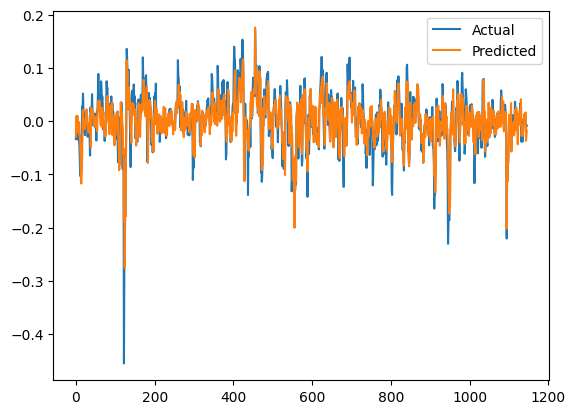

In [39]:
# Make predictions on the training data
y_pred = model.predict(X)

# Plot the actual vs. predicted values
plt.plot(y)
plt.plot(y_pred)
plt.legend(['Actual', 'Predicted'])
plt.show()

In [40]:
#Compute the mean absolute percentage error (MAPE)
epsilon = 1e-10
mape = np.mean(np.abs((y - y_pred) / (y + epsilon))) * 100
print("Mean Absolute Percentage Error (MAPE): ", mape)

Mean Absolute Percentage Error (MAPE):  665.5363165690835


In [41]:
from sklearn.metrics import r2_score

In [42]:
r2 = r2_score(y, y_pred)
print("R-squared: ", r2)

R-squared:  0.6601997599315386


In [154]:
len(y_pred)

1146

In [159]:
predictions_df = pd.DataFrame({'index': estimation_df.index, 'prediction': y_pred.flatten()})
predictions_df.set_index('index', inplace=True)

In [161]:
predictions_df.to_csv('LSTM_predictions.csv', index=True)